In [1]:
import torch
from utils import *
from utils import TemperatureScheduler, calc_ce_loss, TokenizedDataset, DotDict, AutoEncoderTopK
# Example usage:
from transformers import AutoModelForCausalLM, AutoTokenizer
# model_name = "gpt2"
# model_name = "HuggingFaceTB/SmolLM-360M"
model_name = "HuggingFaceTB/SmolLM-135M"
m_name_save= model_name.replace("/", "_")
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = AutoModelForCausalLM.from_pretrained(model_name).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.add_bos_token = True
# batch_size = 512
# batch_size = 32
batch_size = 64
max_length = 128

# Handle datasets, activation layers, etc. for GPT2 vs SmolLM
if(model_name == "gpt2"):
    target_layer = 'transformer.h.5'
    d_name = None
else: 
    target_layer = "model.layers.18"
    d_name = "cosmopedia-v2"
debug = False
if(debug):
    if(model_name == "gpt2"):
        dataset_name = "Elriggs/openwebtext-100k"
    else: 
        dataset_name = "HuggingFaceTB/smollm-corpus"
    num_datapoints = 1_000_000
    # num_datapoints = 400_000
    # num_datapoints = 20_000
    # num_datapoints = 15_000
    # num_datapoints = 2_000
    total_batches = num_datapoints // batch_size
    print(f"total amount of tokens in dataset: {num_datapoints * max_length / 1e6}M")
else:    
    if(model_name == "gpt2"):
        dataset_name = "prithivMLmods/OpenWeb888K"
        num_datapoints = 888_000 # 880_000
        total_batches = 888_000 // batch_size
    else: 
        dataset_name = "HuggingFaceTB/smollm-corpus"
        num_datapoints = 3_000_000
        total_batches = num_datapoints // batch_size
        print(f"total amount of tokens in dataset: {num_datapoints * max_length / 1e6}M")

data_generator = TokenizedDataset(dataset_name, tokenizer, d_name, batch_size=batch_size, max_length=max_length, total_batches=total_batches)

val_data_generator = TokenizedDataset(dataset_name, tokenizer, d_name, batch_size=batch_size, max_length=max_length, total_batches=total_batches, shuffle_seed=98)

total amount of tokens in dataset: 384.0M


Resolving data files:   0%|          | 0/104 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/104 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/104 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/104 [00:00<?, ?it/s]

# Download Pretrained SAE

In [2]:
# Now we want to download all our SAEs
import json
from huggingface_hub import hf_hub_download
huggingface_name = "Elriggs/seq_concat_HuggingFaceTB_SmolLM-135M_model.layers.18"
name_prefix = f"sae_k=30_tokBias=True"
sae_name_style = name_prefix + ".pt"
cfg_name_style = name_prefix + "_cfg.json"

model_path = hf_hub_download(
    repo_id=huggingface_name,
    filename=sae_name_style
)

# Download config file
config_path = hf_hub_download(
    repo_id=huggingface_name,
    filename=cfg_name_style
)
cfg = DotDict(json.load(open(config_path)))

sae = AutoEncoderTopK.from_pretrained(model_path, k=cfg.k, device = None, embedding=True)
print(f"Memory usage: {torch.cuda.memory_allocated()/1024**3:.2f} GB")

sae.to(device)
# print memory  in GB
print(f"Memory usage: {torch.cuda.memory_allocated()/1024**3:.2f} GB")

Memory usage: 0.51 GB
Memory usage: 0.65 GB


# SGLD
Train the LLM, alternating SGD steps & adding noise (ie temperature) to the weights. 
Code & paper from: https://github.com/bfpill/devinterp-1/blob/main/modular_addition/calc_lambda.ipynb
use an elasticity loss (ie difference from original weights) & various scaling terms, which we do not need here.

We've simplified for our case as simply:
weight_update = lr\*gradient + temp\*noise

So scaling the temperature increases the noise, which increases the overall CE loss.

In [ ]:
import os

def update_feature_sim(feature_sim, per_feature_MSE, local_ids, num_features, batch_idx):
    # find out how many times each feature index shows up in local_ids
    num_features = post_relu_feat_acts_BF.shape[-1]
    # Get unique indices and their counts
    unique_indices, counts = torch.unique(local_ids, return_counts=True)

    unique_counts = torch.zeros(num_features, device=local_ids.device)
    unique_counts.index_put_((unique_indices,), counts.float())

    feature_mse_sum = torch.zeros(num_features, device=local_ids.device)
    feature_mse_sum.scatter_add_(0, local_ids.flatten(), per_feature_MSE.flatten())

    # Compute the average MSE for each feature by dividing by its count
    # (avoiding division by zero for features that don't appear)
    feature_mask = unique_counts > 0
    feature_mse_avg = torch.zeros_like(feature_mse_sum)
    feature_mse_avg[feature_mask] = feature_mse_sum[feature_mask] / unique_counts[feature_mask]

    feature_sim[batch_idx, unique_indices] = feature_mse_avg[unique_indices].to("cpu")
    return feature_sim

def sub_bias_and_normalize(x, sae, batch, normalize=True):
    if normalize:
        x = (x - x.mean(dim=-1, keepdim=True)) / (x.std(dim=-1, keepdim=True) + 1e-8)
    if sae.per_token_bias:
        x = x - sae.per_token_bias(batch)
    return x

import math
# lots of code used from https://github.com/bfpill/devinterp-1/blob/main/modular_addition/calc_lambda.ipynb
# feature_sim = torch.ones(total_batches, 9216)*-0.1 # num of features
num_features = sae.encoder.weight.shape[0]
dataset_size = num_datapoints* max_length
noisy_llm_lr = 3e-3  # "epsilon"
adam_and_sae_lr = 1e-4
normalize = True
#temp 5.0e-4 went t. 2.0 & never recovered (also gamm=10)
# Temperature parameters for 1k batches
#Tried 5e-6
max_temp = 1e-5
# max_temp = 5e-6
lowest_temp = max_temp
# lowest_temp = 0.0 # TODO change this
peak_noise_fraction = 0.001
start_decreasing_fraction = 0.8
stay_at_zero_fraction = 0.999
tempScheduler = TemperatureScheduler(
    max_temp,
    lowest_temp,
    peak_noise_fraction,
    start_decreasing_fraction,
    stay_at_zero_fraction
)
# save_checkpoints_every = 10
# batches_to_run = 10 #for validation
save_checkpoints_every = 50
batches_to_run = 20 #for validation


from copy import deepcopy
orig_model = deepcopy(model)
orig_sae = deepcopy(sae)
all_ce_losses = []
# all_elasticity_losses = []
all_ce_diffs = []
fvus = []
# Optimizers
# For the LLM, we start w/ SGD when adding noise (for SLGD), then switch to Adam for "recovering" since that converges better.
sgd_opt = torch.optim.SGD(model.parameters(), lr=noisy_llm_lr)
adam_opt = torch.optim.Adam(model.parameters(), lr=adam_and_sae_lr)
sae_opt = torch.optim.Adam(sae.parameters(), lr=adam_and_sae_lr)
restarted_adam=False
for batch_idx in tqdm(range(total_batches)):

    current_opt = adam_opt if tempScheduler.current_state == "low_temp" else sgd_opt
    current_opt.zero_grad() 
    sae_opt.zero_grad()

    if(cfg.norm_decoder):
        sae.set_decoder_norm_to_unit_norm()
    
    # LLM CE loss (and grab intermediate activation for SAE)
    batch = data_generator.next().to(device)
    with Trace(model, target_layer) as original_trace:
        ce_loss = model(batch, labels=batch).loss
        new_x = original_trace.output[0] if isinstance(original_trace.output, tuple) else original_trace.output
        new_x = new_x.detach()

    full_loss = ce_loss
    full_loss.backward()
    current_opt.step()

    # Check if we need to switch to Adam for "recovering"
    if(tempScheduler.current_state == "low_temp" and not restarted_adam):
        # Restart Adam optimizer
        # Note: I haven't checked if you 
        print("Restarting Adam optimizer")
        # for state in adam_opt.state.values():
        #     state.clear()
        adam_opt = torch.optim.Adam(model.parameters(), lr=1e-5)
        restarted_adam = True

    # SAE
    normalized_new_x = (new_x - new_x.mean(dim=-1, keepdim=True)) / (new_x.std(dim=-1, keepdim=True) + 1e-8)
    bias = sae.per_token_bias(batch)
    x_hat = sae(normalized_new_x - bias) + bias
    with torch.no_grad():
        fvu = calculate_fvu(normalized_new_x, x_hat)
    mse = torch.mean((x_hat - normalized_new_x) ** 2)
    mse.backward()
    if(cfg.norm_decoder):
        sae.remove_gradient_parallel_to_decoder_directions()

    sae_opt.step()

    # Add noise to the parameters
    with torch.no_grad():
        if tempScheduler.current_state != "low_temp":
            temperature = tempScheduler.get_temperature(batch_idx, total_batches)
            new_params = torch.nn.utils.parameters_to_vector(model.parameters()) 
            # noise = torch.randn_like(new_params) * temperature
            t = (temperature)**(0.5)*(noisy_llm_lr)**(0.5)
            noise = torch.randn_like(new_params) * t
            torch.nn.utils.vector_to_parameters(new_params + noise, model.parameters())

    '''
    vars:
    noisy_llm_lr = 5e-4
    '''
    # t = 2e-4: 6k batches (50M tokens) kept going up 
    # t = 9e-5: never went up for 1k batches
    # t = 8e-5: never went up
    # t = (temperature)**(0.5)*(noisy_llm_lr)**(0.5)
    # temperature = t**2/ noisy_llm_lr
    # weight_update =  noisy_llm_lr * gradient + t * noise

    store_data_every = 20
    print_every = 200
    if batch_idx % store_data_every == 0:
        all_ce_losses.append(ce_loss.item())
        with torch.no_grad():
            # Get original model's acts & SAE features
            original_ce_loss = orig_model(batch, labels=batch).loss
            ce_diff = ce_loss - original_ce_loss
        all_ce_diffs.append(ce_diff.item())
        fvus.append(fvu.item())
    if batch_idx % print_every == 0:
        print(f"Batch {batch_idx}/{total_batches}, CE diff: {ce_diff.item():.3f}, fvu: {fvu:.3f} | temperature: {temperature:.1e}")

    #TODO don't forget to flip this later
    store_acts=False
    if(store_acts):
        with torch.no_grad():
            # save first batch info:
            d_model = model.config.hidden_size
            os.makedirs("checkpoints", exist_ok=True)
            # First batch, store the original mdoel's tokens, activations, and CE loss
            if batch_idx == 0:
                # Note: we skip the first token for all activations, tokens to match up w/ CE loss's shape.
                all_tokens = torch.zeros(batches_to_run*batch_size, max_length-1, dtype=torch.long)
                val_original_ce_loss = torch.zeros(batches_to_run*batch_size, max_length-1, dtype=torch.float16)
                all_activations = torch.zeros(batches_to_run*batch_size, max_length-1, d_model, dtype=torch.float16)
                val_data_generator.reset_iterator()
                for i in range(batches_to_run):
                    batch = val_data_generator.next().to(device)
                    with Trace(orig_model, target_layer) as original_trace:
                        original_logits = orig_model(batch, labels=batch, reduction="none").logits
                        original_x = original_trace.output[0] if isinstance(original_trace.output, tuple) else original_trace.output
                        original_x = original_x.detach()
                    ce_loss = calc_ce_loss(original_logits, batch)

                    val_original_ce_loss[i*batch_size:(i+1)*batch_size] = ce_loss.cpu() # already max_len - 1
                    all_activations[i*batch_size:(i+1)*batch_size] = original_x[:, 1:].cpu()
                    all_tokens[i*batch_size:(i+1)*batch_size] = batch[:, 1:].cpu()
                torch.save({
                    "ce_loss": val_original_ce_loss,
                    "all_activations": all_activations,
                    "all_tokens": all_tokens,
                }, f"checkpoints/first_batch_info_skip_first_token.pt")
                # DELETE all tokens
                del all_tokens
                del all_activations
                del val_original_ce_loss
                del original_logits
                del original_trace
                import gc
                gc.collect()
                # clear cache
                torch.cuda.empty_cache()
                
            # Else, we are saving every N checkpoints
            elif (batch_idx) % save_checkpoints_every == 0:
                # if we shoot for 1m tokens then,
                # batches_to_run = 1_000_000 // (batch_size*max_length)
                num_features = orig_sae.encoder.out_features

                # For reasons, we store both original feature acts & new feature acts, even though we could've cached the original SAE features.
                original_feature_acts = torch.zeros(batches_to_run*batch_size, max_length-1, num_features, dtype=torch.float16)
                new_feature_acts = torch.zeros(batches_to_run*batch_size, max_length-1, num_features, dtype=torch.float16)
                val_new_ce_loss = torch.zeros(batches_to_run*batch_size, max_length-1, dtype=torch.float16)
                all_activations = torch.zeros(batches_to_run*batch_size, max_length-1, d_model, dtype=torch.float16)

                print("Saving feature activations")
                for i in tqdm(range(batches_to_run),  total=batches_to_run):
                    batch = val_data_generator.next().to(device)
                    with Trace(model, target_layer) as original_trace:
                        logits = model(batch, labels=batch).logits
                        new_x = original_trace.output[0] if isinstance(original_trace.output, tuple) else original_trace.output
                        new_x = new_x.detach()
                    new_ce_loss = calc_ce_loss(logits, batch)

                    with Trace(orig_model, target_layer) as original_trace:
                        # We could just get the SAE features in first batch, BUT we do need the local_ids of original-SAE for the new one
                        _ = orig_model(batch, labels=batch) # Original CE calculated in first batch
                        old_x = original_trace.output[0] if isinstance(original_trace.output, tuple) else original_trace.output
                        old_x = old_x.detach()

                    # x = x.normalize - bias (so ready for SAE.encode)
                    old_x = sub_bias_and_normalize(old_x, orig_sae, batch, normalize=normalize)
                    new_normalized_x = sub_bias_and_normalize(new_x, sae, batch, normalize=normalize)

                    original_features, local_mags, local_ids = orig_sae.encode(old_x, return_topk=True)

                    post_relu_feat_acts_BF = nn.functional.relu(sae.encoder(new_normalized_x - sae.b_dec))
                    # get the activations at the feature_ids (feature_ids is = to top_indices_BK)
                    custom_feature_acts = post_relu_feat_acts_BF.gather(dim=-1, index=local_ids)
                    buffer_BF = torch.zeros_like(post_relu_feat_acts_BF)
                    custom_features = buffer_BF.scatter_(dim=-1, index=local_ids, src=custom_feature_acts)

                    # feature_sim = update_feature_sim(feature_sim, per_feature_MSE, local_ids, num_features = post_relu_feat_acts_BF.shape[-1], batch_idx=batch_idx)
                    start_idx = i*(batch_size)
                    end_idx = start_idx + (batch_size)  
                    # Let's ignore the first token for all features in general
                    val_new_ce_loss[start_idx:end_idx] = new_ce_loss # first token ignored by default
                    original_feature_acts[start_idx:end_idx] = original_features[:, 1:].cpu() 
                    new_feature_acts[start_idx:end_idx] = custom_features[:, 1:].cpu()
                    all_activations[start_idx:end_idx] = new_x[:, 1:].cpu()

                # save the feature_sim, original_feature_acts, new_feature_acts
                # make  dir if not exists
                torch.save({
                    # "feature_sim": feature_sim,
                    "ce_loss": val_new_ce_loss,
                    "all_activations": all_activations,
                    "original_feature_acts": original_feature_acts,
                    "new_feature_acts": new_feature_acts}, f"checkpoints/feature_sim_{batch_idx}.pt")

  0%|          | 0/46875 [00:00<?, ?it/s]

  0%|          | 1/46875 [00:02<36:13:43,  2.78s/it]

Batch 0/46875, CE diff: 0.000, fvu: 0.117 | temperature: 5.0e-06


  0%|          | 201/46875 [02:09<9:11:35,  1.41it/s]

Batch 200/46875, CE diff: -0.018, fvu: 0.120 | temperature: 5.0e-06


  1%|          | 401/46875 [04:15<9:04:06,  1.42it/s]

Batch 400/46875, CE diff: -0.018, fvu: 0.117 | temperature: 5.0e-06


  1%|▏         | 601/46875 [06:20<9:08:11,  1.41it/s]

Batch 600/46875, CE diff: -0.024, fvu: 0.111 | temperature: 5.0e-06


  2%|▏         | 801/46875 [08:25<8:59:11,  1.42it/s]

Batch 800/46875, CE diff: -0.028, fvu: 0.117 | temperature: 5.0e-06


  2%|▏         | 1001/46875 [10:31<8:52:06,  1.44it/s]

Batch 1000/46875, CE diff: -0.027, fvu: 0.111 | temperature: 5.0e-06


  3%|▎         | 1201/46875 [12:37<9:04:18,  1.40it/s]

Batch 1200/46875, CE diff: -0.024, fvu: 0.116 | temperature: 5.0e-06


  3%|▎         | 1401/46875 [14:42<8:52:02,  1.42it/s]

Batch 1400/46875, CE diff: -0.030, fvu: 0.110 | temperature: 5.0e-06


  3%|▎         | 1601/46875 [16:48<8:44:39,  1.44it/s]

Batch 1600/46875, CE diff: -0.026, fvu: 0.110 | temperature: 5.0e-06


  4%|▍         | 1801/46875 [18:54<8:59:36,  1.39it/s]

Batch 1800/46875, CE diff: -0.028, fvu: 0.109 | temperature: 5.0e-06


  4%|▍         | 2001/46875 [20:59<8:47:41,  1.42it/s]

Batch 2000/46875, CE diff: -0.032, fvu: 0.115 | temperature: 5.0e-06


  5%|▍         | 2201/46875 [23:05<8:39:34,  1.43it/s]

Batch 2200/46875, CE diff: -0.031, fvu: 0.113 | temperature: 5.0e-06


  5%|▌         | 2401/46875 [25:12<8:54:20,  1.39it/s]

Batch 2400/46875, CE diff: -0.034, fvu: 0.113 | temperature: 5.0e-06


  6%|▌         | 2601/46875 [27:17<8:38:05,  1.42it/s]

Batch 2600/46875, CE diff: -0.025, fvu: 0.113 | temperature: 5.0e-06


  6%|▌         | 2801/46875 [29:24<8:28:21,  1.44it/s]

Batch 2800/46875, CE diff: -0.028, fvu: 0.112 | temperature: 5.0e-06


  6%|▋         | 3001/46875 [31:29<8:45:27,  1.39it/s]

Batch 3000/46875, CE diff: -0.034, fvu: 0.113 | temperature: 5.0e-06


  7%|▋         | 3201/46875 [33:34<8:29:32,  1.43it/s]

Batch 3200/46875, CE diff: -0.030, fvu: 0.112 | temperature: 5.0e-06


  7%|▋         | 3401/46875 [35:40<8:24:24,  1.44it/s]

Batch 3400/46875, CE diff: -0.037, fvu: 0.110 | temperature: 5.0e-06


  8%|▊         | 3601/46875 [37:45<8:46:59,  1.37it/s]

Batch 3600/46875, CE diff: -0.037, fvu: 0.112 | temperature: 5.0e-06


  8%|▊         | 3801/46875 [39:51<8:23:06,  1.43it/s]

Batch 3800/46875, CE diff: -0.034, fvu: 0.113 | temperature: 5.0e-06


  9%|▊         | 4001/46875 [41:58<8:14:44,  1.44it/s]

Batch 4000/46875, CE diff: -0.031, fvu: 0.114 | temperature: 5.0e-06


  9%|▉         | 4201/46875 [44:03<8:33:06,  1.39it/s]

Batch 4200/46875, CE diff: -0.029, fvu: 0.114 | temperature: 5.0e-06


  9%|▉         | 4401/46875 [46:09<8:16:42,  1.43it/s]

Batch 4400/46875, CE diff: -0.030, fvu: 0.115 | temperature: 5.0e-06


 10%|▉         | 4601/46875 [48:15<8:14:23,  1.43it/s]

Batch 4600/46875, CE diff: -0.033, fvu: 0.115 | temperature: 5.0e-06


 10%|█         | 4801/46875 [50:20<8:21:36,  1.40it/s]

Batch 4800/46875, CE diff: -0.030, fvu: 0.112 | temperature: 5.0e-06


 11%|█         | 5001/46875 [52:26<8:06:48,  1.43it/s]

Batch 5000/46875, CE diff: -0.034, fvu: 0.115 | temperature: 5.0e-06


 11%|█         | 5201/46875 [54:32<8:11:31,  1.41it/s]

Batch 5200/46875, CE diff: -0.027, fvu: 0.113 | temperature: 5.0e-06


 12%|█▏        | 5401/46875 [56:38<8:17:20,  1.39it/s]

Batch 5400/46875, CE diff: -0.038, fvu: 0.117 | temperature: 5.0e-06


 12%|█▏        | 5601/46875 [58:44<8:06:41,  1.41it/s]

Batch 5600/46875, CE diff: -0.035, fvu: 0.117 | temperature: 5.0e-06


 12%|█▏        | 5801/46875 [1:00:51<7:59:45,  1.43it/s]

Batch 5800/46875, CE diff: -0.032, fvu: 0.113 | temperature: 5.0e-06


 13%|█▎        | 6001/46875 [1:03:01<8:01:26,  1.41it/s] 

Batch 6000/46875, CE diff: -0.023, fvu: 0.112 | temperature: 5.0e-06


 13%|█▎        | 6201/46875 [1:05:06<7:54:22,  1.43it/s]

Batch 6200/46875, CE diff: -0.033, fvu: 0.111 | temperature: 5.0e-06


 14%|█▎        | 6401/46875 [1:07:12<7:49:32,  1.44it/s]

Batch 6400/46875, CE diff: -0.034, fvu: 0.115 | temperature: 5.0e-06


 14%|█▍        | 6601/46875 [1:09:17<7:56:19,  1.41it/s]

Batch 6600/46875, CE diff: -0.027, fvu: 0.112 | temperature: 5.0e-06


 15%|█▍        | 6801/46875 [1:11:22<7:46:17,  1.43it/s]

Batch 6800/46875, CE diff: -0.023, fvu: 0.109 | temperature: 5.0e-06


 15%|█▍        | 7001/46875 [1:13:28<7:42:59,  1.44it/s]

Batch 7000/46875, CE diff: -0.028, fvu: 0.111 | temperature: 5.0e-06


 15%|█▌        | 7201/46875 [1:15:33<7:52:26,  1.40it/s]

Batch 7200/46875, CE diff: -0.022, fvu: 0.117 | temperature: 5.0e-06


 16%|█▌        | 7401/46875 [1:17:38<7:39:17,  1.43it/s]

Batch 7400/46875, CE diff: -0.045, fvu: 0.111 | temperature: 5.0e-06


 16%|█▌        | 7601/46875 [1:19:45<7:42:35,  1.42it/s]

Batch 7600/46875, CE diff: -0.027, fvu: 0.113 | temperature: 5.0e-06


 17%|█▋        | 7801/46875 [1:21:49<7:44:48,  1.40it/s]

Batch 7800/46875, CE diff: -0.032, fvu: 0.116 | temperature: 5.0e-06


 17%|█▋        | 8001/46875 [1:23:55<7:30:47,  1.44it/s]

Batch 8000/46875, CE diff: -0.025, fvu: 0.111 | temperature: 5.0e-06


 17%|█▋        | 8201/46875 [1:26:01<7:29:53,  1.43it/s]

Batch 8200/46875, CE diff: -0.024, fvu: 0.113 | temperature: 5.0e-06


 18%|█▊        | 8401/46875 [1:28:06<7:38:59,  1.40it/s]

Batch 8400/46875, CE diff: -0.032, fvu: 0.113 | temperature: 5.0e-06


 18%|█▊        | 8601/46875 [1:30:13<7:28:17,  1.42it/s]

Batch 8600/46875, CE diff: -0.029, fvu: 0.112 | temperature: 5.0e-06


 19%|█▉        | 8801/46875 [1:32:20<7:27:07,  1.42it/s]

Batch 8800/46875, CE diff: -0.026, fvu: 0.117 | temperature: 5.0e-06


 19%|█▉        | 9001/46875 [1:34:25<7:32:39,  1.39it/s]

Batch 9000/46875, CE diff: -0.027, fvu: 0.113 | temperature: 5.0e-06


 20%|█▉        | 9201/46875 [1:36:31<7:16:19,  1.44it/s]

Batch 9200/46875, CE diff: -0.027, fvu: 0.111 | temperature: 5.0e-06


 20%|██        | 9401/46875 [1:38:37<7:19:45,  1.42it/s]

Batch 9400/46875, CE diff: -0.020, fvu: 0.115 | temperature: 5.0e-06


 20%|██        | 9601/46875 [1:40:42<7:25:12,  1.40it/s]

Batch 9600/46875, CE diff: -0.028, fvu: 0.111 | temperature: 5.0e-06


 21%|██        | 9801/46875 [1:42:49<7:14:47,  1.42it/s]

Batch 9800/46875, CE diff: -0.033, fvu: 0.111 | temperature: 5.0e-06


 21%|██▏       | 10001/46875 [1:44:56<7:12:32,  1.42it/s]

Batch 10000/46875, CE diff: -0.032, fvu: 0.111 | temperature: 5.0e-06


 22%|██▏       | 10201/46875 [1:47:00<7:15:24,  1.40it/s]

Batch 10200/46875, CE diff: -0.030, fvu: 0.117 | temperature: 5.0e-06


 22%|██▏       | 10401/46875 [1:49:07<7:02:56,  1.44it/s]

Batch 10400/46875, CE diff: -0.027, fvu: 0.118 | temperature: 5.0e-06


 23%|██▎       | 10601/46875 [1:51:13<7:09:08,  1.41it/s]

Batch 10600/46875, CE diff: -0.029, fvu: 0.118 | temperature: 5.0e-06


 23%|██▎       | 10801/46875 [1:53:18<7:10:49,  1.40it/s]

Batch 10800/46875, CE diff: -0.035, fvu: 0.105 | temperature: 5.0e-06


 23%|██▎       | 11001/46875 [1:55:24<6:58:22,  1.43it/s]

Batch 11000/46875, CE diff: -0.032, fvu: 0.118 | temperature: 5.0e-06


 24%|██▍       | 11201/46875 [1:57:31<7:04:20,  1.40it/s]

Batch 11200/46875, CE diff: -0.023, fvu: 0.111 | temperature: 5.0e-06


 24%|██▍       | 11401/46875 [1:59:36<6:57:58,  1.41it/s]

Batch 11400/46875, CE diff: -0.025, fvu: 0.112 | temperature: 5.0e-06


 25%|██▍       | 11601/46875 [2:01:42<6:49:12,  1.44it/s]

Batch 11600/46875, CE diff: -0.027, fvu: 0.114 | temperature: 5.0e-06


 25%|██▌       | 11801/46875 [2:03:50<6:57:30,  1.40it/s] 

Batch 11800/46875, CE diff: -0.029, fvu: 0.110 | temperature: 5.0e-06


 26%|██▌       | 12001/46875 [2:05:54<6:49:15,  1.42it/s]

Batch 12000/46875, CE diff: -0.030, fvu: 0.118 | temperature: 5.0e-06


 26%|██▌       | 12201/46875 [2:08:01<6:43:12,  1.43it/s]

Batch 12200/46875, CE diff: -0.030, fvu: 0.112 | temperature: 5.0e-06


 26%|██▋       | 12401/46875 [2:10:06<6:48:55,  1.41it/s]

Batch 12400/46875, CE diff: -0.023, fvu: 0.112 | temperature: 5.0e-06


 27%|██▋       | 12601/46875 [2:12:11<6:44:32,  1.41it/s]

Batch 12600/46875, CE diff: -0.022, fvu: 0.113 | temperature: 5.0e-06


 27%|██▋       | 12801/46875 [2:14:18<6:38:03,  1.43it/s]

Batch 12800/46875, CE diff: -0.026, fvu: 0.109 | temperature: 5.0e-06


 28%|██▊       | 13001/46875 [2:16:24<6:40:56,  1.41it/s]

Batch 13000/46875, CE diff: -0.032, fvu: 0.111 | temperature: 5.0e-06


 28%|██▊       | 13201/46875 [2:18:29<6:35:31,  1.42it/s]

Batch 13200/46875, CE diff: -0.020, fvu: 0.113 | temperature: 5.0e-06


 29%|██▊       | 13401/46875 [2:20:35<6:26:52,  1.44it/s]

Batch 13400/46875, CE diff: -0.017, fvu: 0.117 | temperature: 5.0e-06


 29%|██▉       | 13601/46875 [2:22:40<6:31:49,  1.42it/s]

Batch 13600/46875, CE diff: -0.031, fvu: 0.118 | temperature: 5.0e-06


 29%|██▉       | 13801/46875 [2:24:45<6:26:22,  1.43it/s]

Batch 13800/46875, CE diff: -0.028, fvu: 0.113 | temperature: 5.0e-06


 30%|██▉       | 14001/46875 [2:26:51<6:19:17,  1.44it/s]

Batch 14000/46875, CE diff: -0.030, fvu: 0.112 | temperature: 5.0e-06


 30%|███       | 14201/46875 [2:28:57<6:26:41,  1.41it/s]

Batch 14200/46875, CE diff: -0.032, fvu: 0.113 | temperature: 5.0e-06


 31%|███       | 14401/46875 [2:31:02<6:22:56,  1.41it/s]

Batch 14400/46875, CE diff: -0.027, fvu: 0.116 | temperature: 5.0e-06


 31%|███       | 14601/46875 [2:33:08<6:12:59,  1.44it/s]

Batch 14600/46875, CE diff: -0.027, fvu: 0.112 | temperature: 5.0e-06


 32%|███▏      | 14801/46875 [2:35:14<6:23:23,  1.39it/s]

Batch 14800/46875, CE diff: -0.025, fvu: 0.115 | temperature: 5.0e-06


 32%|███▏      | 15001/46875 [2:37:19<6:16:42,  1.41it/s]

Batch 15000/46875, CE diff: -0.030, fvu: 0.110 | temperature: 5.0e-06


 32%|███▏      | 15201/46875 [2:39:25<6:06:48,  1.44it/s]

Batch 15200/46875, CE diff: -0.023, fvu: 0.115 | temperature: 5.0e-06


 33%|███▎      | 15401/46875 [2:41:31<6:13:42,  1.40it/s]

Batch 15400/46875, CE diff: -0.024, fvu: 0.109 | temperature: 5.0e-06


 33%|███▎      | 15601/46875 [2:43:36<6:07:40,  1.42it/s]

Batch 15600/46875, CE diff: -0.023, fvu: 0.110 | temperature: 5.0e-06


 34%|███▎      | 15801/46875 [2:45:42<5:58:44,  1.44it/s]

Batch 15800/46875, CE diff: -0.020, fvu: 0.115 | temperature: 5.0e-06


 34%|███▍      | 16001/46875 [2:47:48<6:06:30,  1.40it/s]

Batch 16000/46875, CE diff: -0.023, fvu: 0.112 | temperature: 5.0e-06


 35%|███▍      | 16201/46875 [2:49:52<6:00:18,  1.42it/s]

Batch 16200/46875, CE diff: -0.022, fvu: 0.112 | temperature: 5.0e-06


 35%|███▍      | 16401/46875 [2:51:59<5:53:56,  1.43it/s]

Batch 16400/46875, CE diff: -0.027, fvu: 0.113 | temperature: 5.0e-06


 35%|███▌      | 16601/46875 [2:54:05<6:01:17,  1.40it/s]

Batch 16600/46875, CE diff: -0.029, fvu: 0.113 | temperature: 5.0e-06


 36%|███▌      | 16801/46875 [2:56:10<5:50:36,  1.43it/s]

Batch 16800/46875, CE diff: -0.025, fvu: 0.113 | temperature: 5.0e-06


 36%|███▋      | 17001/46875 [2:58:16<5:48:36,  1.43it/s]

Batch 17000/46875, CE diff: -0.021, fvu: 0.110 | temperature: 5.0e-06


 37%|███▋      | 17201/46875 [3:00:21<5:56:34,  1.39it/s]

Batch 17200/46875, CE diff: -0.022, fvu: 0.113 | temperature: 5.0e-06


 37%|███▋      | 17401/46875 [3:02:27<5:44:33,  1.43it/s]

Batch 17400/46875, CE diff: -0.037, fvu: 0.114 | temperature: 5.0e-06


 38%|███▊      | 17601/46875 [3:04:33<5:41:10,  1.43it/s]

Batch 17600/46875, CE diff: -0.018, fvu: 0.115 | temperature: 5.0e-06


 38%|███▊      | 17801/46875 [3:06:41<5:45:11,  1.40it/s] 

Batch 17800/46875, CE diff: -0.028, fvu: 0.118 | temperature: 5.0e-06


 38%|███▊      | 18001/46875 [3:08:47<5:41:33,  1.41it/s]

Batch 18000/46875, CE diff: -0.017, fvu: 0.108 | temperature: 5.0e-06


 39%|███▉      | 18201/46875 [3:10:53<5:33:13,  1.43it/s]

Batch 18200/46875, CE diff: -0.031, fvu: 0.111 | temperature: 5.0e-06


 39%|███▉      | 18401/46875 [3:13:00<5:39:46,  1.40it/s]

Batch 18400/46875, CE diff: -0.031, fvu: 0.110 | temperature: 5.0e-06


 40%|███▉      | 18601/46875 [3:15:05<5:34:47,  1.41it/s]

Batch 18600/46875, CE diff: -0.021, fvu: 0.116 | temperature: 5.0e-06


 40%|████      | 18801/46875 [3:17:12<5:25:58,  1.44it/s]

Batch 18800/46875, CE diff: -0.024, fvu: 0.112 | temperature: 5.0e-06


 41%|████      | 19001/46875 [3:19:18<5:32:07,  1.40it/s]

Batch 19000/46875, CE diff: -0.020, fvu: 0.116 | temperature: 5.0e-06


 41%|████      | 19201/46875 [3:21:22<5:25:54,  1.42it/s]

Batch 19200/46875, CE diff: -0.022, fvu: 0.113 | temperature: 5.0e-06


 41%|████▏     | 19401/46875 [3:23:29<5:19:52,  1.43it/s]

Batch 19400/46875, CE diff: -0.022, fvu: 0.114 | temperature: 5.0e-06


 42%|████▏     | 19601/46875 [3:25:36<5:28:41,  1.38it/s]

Batch 19600/46875, CE diff: -0.013, fvu: 0.109 | temperature: 5.0e-06


 42%|████▏     | 19801/46875 [3:27:42<5:18:21,  1.42it/s]

Batch 19800/46875, CE diff: -0.021, fvu: 0.108 | temperature: 5.0e-06


 43%|████▎     | 20001/46875 [3:29:49<5:18:54,  1.40it/s]

Batch 20000/46875, CE diff: -0.023, fvu: 0.113 | temperature: 5.0e-06


 43%|████▎     | 20201/46875 [3:31:55<5:16:23,  1.41it/s]

Batch 20200/46875, CE diff: -0.027, fvu: 0.112 | temperature: 5.0e-06


 44%|████▎     | 20401/46875 [3:34:00<5:10:48,  1.42it/s]

Batch 20400/46875, CE diff: -0.017, fvu: 0.112 | temperature: 5.0e-06


 44%|████▍     | 20601/46875 [3:36:06<5:07:48,  1.42it/s]

Batch 20600/46875, CE diff: -0.019, fvu: 0.116 | temperature: 5.0e-06


 44%|████▍     | 20801/46875 [3:38:12<5:15:39,  1.38it/s]

Batch 20800/46875, CE diff: -0.015, fvu: 0.112 | temperature: 5.0e-06


 45%|████▍     | 21001/46875 [3:40:17<5:02:07,  1.43it/s]

Batch 21000/46875, CE diff: -0.026, fvu: 0.114 | temperature: 5.0e-06


 45%|████▌     | 21201/46875 [3:42:24<4:58:06,  1.44it/s]

Batch 21200/46875, CE diff: -0.017, fvu: 0.111 | temperature: 5.0e-06


 46%|████▌     | 21401/46875 [3:44:29<5:07:59,  1.38it/s]

Batch 21400/46875, CE diff: -0.022, fvu: 0.113 | temperature: 5.0e-06


 46%|████▌     | 21601/46875 [3:46:34<4:54:07,  1.43it/s]

Batch 21600/46875, CE diff: -0.016, fvu: 0.111 | temperature: 5.0e-06


 47%|████▋     | 21801/46875 [3:48:41<4:51:20,  1.43it/s]

Batch 21800/46875, CE diff: -0.023, fvu: 0.111 | temperature: 5.0e-06


 47%|████▋     | 22001/46875 [3:50:45<5:00:10,  1.38it/s]

Batch 22000/46875, CE diff: -0.026, fvu: 0.115 | temperature: 5.0e-06


 47%|████▋     | 22201/46875 [3:52:51<4:49:23,  1.42it/s]

Batch 22200/46875, CE diff: -0.017, fvu: 0.110 | temperature: 5.0e-06


 48%|████▊     | 22401/46875 [3:54:57<4:44:44,  1.43it/s]

Batch 22400/46875, CE diff: -0.021, fvu: 0.110 | temperature: 5.0e-06


 48%|████▊     | 22601/46875 [3:57:02<4:50:34,  1.39it/s]

Batch 22600/46875, CE diff: -0.015, fvu: 0.112 | temperature: 5.0e-06


 49%|████▊     | 22801/46875 [3:59:09<4:42:32,  1.42it/s]

Batch 22800/46875, CE diff: -0.011, fvu: 0.112 | temperature: 5.0e-06


 49%|████▉     | 23001/46875 [4:01:15<4:38:58,  1.43it/s]

Batch 23000/46875, CE diff: -0.026, fvu: 0.116 | temperature: 5.0e-06


 49%|████▉     | 23201/46875 [4:03:21<4:40:32,  1.41it/s]

Batch 23200/46875, CE diff: -0.022, fvu: 0.115 | temperature: 5.0e-06


 50%|████▉     | 23401/46875 [4:05:26<4:31:25,  1.44it/s]

Batch 23400/46875, CE diff: -0.010, fvu: 0.110 | temperature: 5.0e-06


 50%|█████     | 23601/46875 [4:07:37<4:35:52,  1.41it/s] 

Batch 23600/46875, CE diff: -0.007, fvu: 0.114 | temperature: 5.0e-06


 51%|█████     | 23801/46875 [4:09:42<4:30:29,  1.42it/s]

Batch 23800/46875, CE diff: -0.025, fvu: 0.113 | temperature: 5.0e-06


 51%|█████     | 24001/46875 [4:11:48<4:25:22,  1.44it/s]

Batch 24000/46875, CE diff: -0.014, fvu: 0.113 | temperature: 5.0e-06


 52%|█████▏    | 24201/46875 [4:13:54<4:28:21,  1.41it/s]

Batch 24200/46875, CE diff: -0.012, fvu: 0.112 | temperature: 5.0e-06


 52%|█████▏    | 24401/46875 [4:15:58<4:24:06,  1.42it/s]

Batch 24400/46875, CE diff: -0.013, fvu: 0.115 | temperature: 5.0e-06


 52%|█████▏    | 24601/46875 [4:18:04<4:18:08,  1.44it/s]

Batch 24600/46875, CE diff: -0.020, fvu: 0.110 | temperature: 5.0e-06


 53%|█████▎    | 24801/46875 [4:20:10<4:21:27,  1.41it/s]

Batch 24800/46875, CE diff: -0.024, fvu: 0.115 | temperature: 5.0e-06


 53%|█████▎    | 25001/46875 [4:22:15<4:18:52,  1.41it/s]

Batch 25000/46875, CE diff: -0.020, fvu: 0.106 | temperature: 5.0e-06


 54%|█████▍    | 25201/46875 [4:24:21<4:10:53,  1.44it/s]

Batch 25200/46875, CE diff: -0.012, fvu: 0.113 | temperature: 5.0e-06


 54%|█████▍    | 25401/46875 [4:26:27<4:15:10,  1.40it/s]

Batch 25400/46875, CE diff: -0.014, fvu: 0.113 | temperature: 5.0e-06


 55%|█████▍    | 25601/46875 [4:28:31<4:08:59,  1.42it/s]

Batch 25600/46875, CE diff: -0.019, fvu: 0.113 | temperature: 5.0e-06


 55%|█████▌    | 25801/46875 [4:30:37<4:03:27,  1.44it/s]

Batch 25800/46875, CE diff: -0.012, fvu: 0.113 | temperature: 5.0e-06


 55%|█████▌    | 26001/46875 [4:32:43<4:07:59,  1.40it/s]

Batch 26000/46875, CE diff: -0.018, fvu: 0.113 | temperature: 5.0e-06


 56%|█████▌    | 26201/46875 [4:34:48<4:04:01,  1.41it/s]

Batch 26200/46875, CE diff: -0.008, fvu: 0.111 | temperature: 5.0e-06


 56%|█████▋    | 26401/46875 [4:36:54<3:57:19,  1.44it/s]

Batch 26400/46875, CE diff: -0.021, fvu: 0.112 | temperature: 5.0e-06


 57%|█████▋    | 26601/46875 [4:39:00<4:02:19,  1.39it/s]

Batch 26600/46875, CE diff: -0.015, fvu: 0.117 | temperature: 5.0e-06


 57%|█████▋    | 26801/46875 [4:41:05<3:57:04,  1.41it/s]

Batch 26800/46875, CE diff: -0.023, fvu: 0.109 | temperature: 5.0e-06


 58%|█████▊    | 27001/46875 [4:43:12<3:54:09,  1.41it/s]

Batch 27000/46875, CE diff: -0.019, fvu: 0.108 | temperature: 5.0e-06


 58%|█████▊    | 27201/46875 [4:45:18<3:57:18,  1.38it/s]

Batch 27200/46875, CE diff: -0.021, fvu: 0.109 | temperature: 5.0e-06


 58%|█████▊    | 27401/46875 [4:47:23<3:47:03,  1.43it/s]

Batch 27400/46875, CE diff: -0.017, fvu: 0.115 | temperature: 5.0e-06


 59%|█████▉    | 27601/46875 [4:49:29<3:44:36,  1.43it/s]

Batch 27600/46875, CE diff: -0.015, fvu: 0.111 | temperature: 5.0e-06


 59%|█████▉    | 27801/46875 [4:51:34<3:49:47,  1.38it/s]

Batch 27800/46875, CE diff: -0.008, fvu: 0.117 | temperature: 5.0e-06


 60%|█████▉    | 28001/46875 [4:53:39<3:39:11,  1.44it/s]

Batch 28000/46875, CE diff: -0.007, fvu: 0.109 | temperature: 5.0e-06


 60%|██████    | 28201/46875 [4:55:45<3:37:50,  1.43it/s]

Batch 28200/46875, CE diff: -0.012, fvu: 0.117 | temperature: 5.0e-06


 61%|██████    | 28401/46875 [4:57:50<3:41:57,  1.39it/s]

Batch 28400/46875, CE diff: -0.007, fvu: 0.114 | temperature: 5.0e-06


 61%|██████    | 28601/46875 [4:59:56<3:35:13,  1.42it/s]

Batch 28600/46875, CE diff: -0.013, fvu: 0.113 | temperature: 5.0e-06


 61%|██████▏   | 28801/46875 [5:02:03<3:29:34,  1.44it/s]

Batch 28800/46875, CE diff: -0.006, fvu: 0.113 | temperature: 5.0e-06


 62%|██████▏   | 29001/46875 [5:04:08<3:34:36,  1.39it/s]

Batch 29000/46875, CE diff: -0.013, fvu: 0.112 | temperature: 5.0e-06


 62%|██████▏   | 29201/46875 [5:06:14<3:27:29,  1.42it/s]

Batch 29200/46875, CE diff: -0.011, fvu: 0.111 | temperature: 5.0e-06


 63%|██████▎   | 29401/46875 [5:08:26<3:25:49,  1.41it/s]

Batch 29400/46875, CE diff: -0.015, fvu: 0.112 | temperature: 5.0e-06


 63%|██████▎   | 29601/46875 [5:10:31<3:27:16,  1.39it/s]

Batch 29600/46875, CE diff: -0.022, fvu: 0.114 | temperature: 5.0e-06


 64%|██████▎   | 29801/46875 [5:12:36<3:19:03,  1.43it/s]

Batch 29800/46875, CE diff: -0.007, fvu: 0.113 | temperature: 5.0e-06


 64%|██████▍   | 30001/46875 [5:14:42<3:15:52,  1.44it/s]

Batch 30000/46875, CE diff: -0.020, fvu: 0.111 | temperature: 5.0e-06


 64%|██████▍   | 30201/46875 [5:16:47<3:21:29,  1.38it/s]

Batch 30200/46875, CE diff: -0.009, fvu: 0.116 | temperature: 5.0e-06


 65%|██████▍   | 30401/46875 [5:18:53<3:13:29,  1.42it/s]

Batch 30400/46875, CE diff: -0.015, fvu: 0.114 | temperature: 5.0e-06


 65%|██████▌   | 30601/46875 [5:21:00<3:10:11,  1.43it/s]

Batch 30600/46875, CE diff: -0.013, fvu: 0.113 | temperature: 5.0e-06


 66%|██████▌   | 30801/46875 [5:23:05<3:14:18,  1.38it/s]

Batch 30800/46875, CE diff: -0.017, fvu: 0.115 | temperature: 5.0e-06


 66%|██████▌   | 31001/46875 [5:25:11<3:06:31,  1.42it/s]

Batch 31000/46875, CE diff: -0.014, fvu: 0.110 | temperature: 5.0e-06


 67%|██████▋   | 31201/46875 [5:27:18<3:02:30,  1.43it/s]

Batch 31200/46875, CE diff: -0.019, fvu: 0.112 | temperature: 5.0e-06


 67%|██████▋   | 31401/46875 [5:29:23<3:07:06,  1.38it/s]

Batch 31400/46875, CE diff: -0.008, fvu: 0.113 | temperature: 5.0e-06


 67%|██████▋   | 31601/46875 [5:31:29<2:57:22,  1.44it/s]

Batch 31600/46875, CE diff: -0.005, fvu: 0.109 | temperature: 5.0e-06


 68%|██████▊   | 31801/46875 [5:33:35<2:55:21,  1.43it/s]

Batch 31800/46875, CE diff: -0.010, fvu: 0.111 | temperature: 5.0e-06


 68%|██████▊   | 32001/46875 [5:35:41<2:59:32,  1.38it/s]

Batch 32000/46875, CE diff: -0.013, fvu: 0.108 | temperature: 5.0e-06


 69%|██████▊   | 32201/46875 [5:37:47<2:51:14,  1.43it/s]

Batch 32200/46875, CE diff: -0.022, fvu: 0.112 | temperature: 5.0e-06


 69%|██████▉   | 32401/46875 [5:39:54<2:50:46,  1.41it/s]

Batch 32400/46875, CE diff: -0.016, fvu: 0.110 | temperature: 5.0e-06


 70%|██████▉   | 32601/46875 [5:41:59<2:49:45,  1.40it/s]

Batch 32600/46875, CE diff: -0.007, fvu: 0.110 | temperature: 5.0e-06


 70%|██████▉   | 32801/46875 [5:44:05<2:43:07,  1.44it/s]

Batch 32800/46875, CE diff: -0.005, fvu: 0.109 | temperature: 5.0e-06


 70%|███████   | 33001/46875 [5:46:11<2:43:21,  1.42it/s]

Batch 33000/46875, CE diff: -0.011, fvu: 0.117 | temperature: 5.0e-06


 71%|███████   | 33201/46875 [5:48:16<2:43:17,  1.40it/s]

Batch 33200/46875, CE diff: -0.015, fvu: 0.112 | temperature: 5.0e-06


 71%|███████▏  | 33401/46875 [5:50:23<2:37:06,  1.43it/s]

Batch 33400/46875, CE diff: -0.005, fvu: 0.112 | temperature: 5.0e-06


 72%|███████▏  | 33601/46875 [5:52:29<2:36:26,  1.41it/s]

Batch 33600/46875, CE diff: 0.004, fvu: 0.111 | temperature: 5.0e-06


 72%|███████▏  | 33801/46875 [5:54:35<2:35:49,  1.40it/s]

Batch 33800/46875, CE diff: -0.022, fvu: 0.115 | temperature: 5.0e-06


 73%|███████▎  | 34001/46875 [5:56:41<2:29:58,  1.43it/s]

Batch 34000/46875, CE diff: 0.006, fvu: 0.113 | temperature: 5.0e-06


 73%|███████▎  | 34201/46875 [5:58:48<2:28:28,  1.42it/s]

Batch 34200/46875, CE diff: -0.007, fvu: 0.111 | temperature: 5.0e-06


 73%|███████▎  | 34401/46875 [6:00:53<2:28:18,  1.40it/s]

Batch 34400/46875, CE diff: -0.013, fvu: 0.111 | temperature: 5.0e-06


 74%|███████▍  | 34601/46875 [6:02:59<2:23:23,  1.43it/s]

Batch 34600/46875, CE diff: -0.020, fvu: 0.111 | temperature: 5.0e-06


 74%|███████▍  | 34801/46875 [6:05:06<2:21:06,  1.43it/s]

Batch 34800/46875, CE diff: -0.007, fvu: 0.109 | temperature: 5.0e-06


 75%|███████▍  | 35001/46875 [6:07:11<2:20:30,  1.41it/s]

Batch 35000/46875, CE diff: -0.015, fvu: 0.117 | temperature: 5.0e-06


 75%|███████▌  | 35201/46875 [6:09:17<2:16:12,  1.43it/s]

Batch 35200/46875, CE diff: -0.010, fvu: 0.109 | temperature: 5.0e-06


 76%|███████▌  | 35401/46875 [6:11:27<2:14:38,  1.42it/s]

Batch 35400/46875, CE diff: -0.013, fvu: 0.110 | temperature: 5.0e-06


 76%|███████▌  | 35601/46875 [6:13:31<2:13:41,  1.41it/s]

Batch 35600/46875, CE diff: -0.006, fvu: 0.113 | temperature: 5.0e-06


 76%|███████▋  | 35801/46875 [6:15:37<2:08:30,  1.44it/s]

Batch 35800/46875, CE diff: -0.012, fvu: 0.113 | temperature: 5.0e-06


 77%|███████▋  | 36001/46875 [6:17:43<2:08:51,  1.41it/s]

Batch 36000/46875, CE diff: -0.013, fvu: 0.115 | temperature: 5.0e-06


 77%|███████▋  | 36201/46875 [6:19:49<2:05:59,  1.41it/s]

Batch 36200/46875, CE diff: -0.009, fvu: 0.110 | temperature: 5.0e-06


 78%|███████▊  | 36401/46875 [6:21:55<2:01:58,  1.43it/s]

Batch 36400/46875, CE diff: -0.009, fvu: 0.109 | temperature: 5.0e-06


 78%|███████▊  | 36601/46875 [6:24:01<2:01:55,  1.40it/s]

Batch 36600/46875, CE diff: -0.009, fvu: 0.113 | temperature: 5.0e-06


 79%|███████▊  | 36801/46875 [6:26:06<1:58:16,  1.42it/s]

Batch 36800/46875, CE diff: -0.014, fvu: 0.109 | temperature: 5.0e-06


 79%|███████▉  | 37001/46875 [6:28:12<1:53:35,  1.45it/s]

Batch 37000/46875, CE diff: -0.008, fvu: 0.111 | temperature: 5.0e-06


 79%|███████▉  | 37201/46875 [6:30:17<1:55:30,  1.40it/s]

Batch 37200/46875, CE diff: -0.004, fvu: 0.107 | temperature: 5.0e-06


 80%|███████▉  | 37401/46875 [6:32:23<1:48:53,  1.45it/s]

Batch 37400/46875, CE diff: -0.001, fvu: 0.110 | temperature: 5.0e-06


 80%|████████  | 37601/46875 [6:34:29<1:49:52,  1.41it/s]

Batch 37600/46875, CE diff: -0.010, fvu: 0.114 | temperature: 5.0e-06


 81%|████████  | 37801/46875 [6:36:35<1:50:07,  1.37it/s]

Batch 37800/46875, CE diff: -0.004, fvu: 0.109 | temperature: 5.0e-06


 81%|████████  | 38001/46875 [6:38:41<1:43:59,  1.42it/s]

Batch 38000/46875, CE diff: -0.001, fvu: 0.109 | temperature: 5.0e-06


 81%|████████▏ | 38201/46875 [6:40:48<1:40:46,  1.43it/s]

Batch 38200/46875, CE diff: -0.004, fvu: 0.106 | temperature: 5.0e-06


 82%|████████▏ | 38401/46875 [6:42:54<1:41:56,  1.39it/s]

Batch 38400/46875, CE diff: -0.022, fvu: 0.114 | temperature: 5.0e-06


 82%|████████▏ | 38601/46875 [6:45:00<1:37:05,  1.42it/s]

Batch 38600/46875, CE diff: -0.011, fvu: 0.118 | temperature: 5.0e-06


 83%|████████▎ | 38801/46875 [6:47:07<1:34:29,  1.42it/s]

Batch 38800/46875, CE diff: -0.011, fvu: 0.110 | temperature: 5.0e-06


 83%|████████▎ | 39001/46875 [6:49:13<1:33:38,  1.40it/s]

Batch 39000/46875, CE diff: -0.003, fvu: 0.109 | temperature: 5.0e-06


 84%|████████▎ | 39201/46875 [6:51:19<1:29:13,  1.43it/s]

Batch 39200/46875, CE diff: -0.011, fvu: 0.114 | temperature: 5.0e-06


 84%|████████▍ | 39401/46875 [6:53:26<1:27:38,  1.42it/s]

Batch 39400/46875, CE diff: -0.003, fvu: 0.111 | temperature: 5.0e-06


 84%|████████▍ | 39601/46875 [6:55:31<1:26:16,  1.41it/s]

Batch 39600/46875, CE diff: -0.009, fvu: 0.112 | temperature: 5.0e-06


 85%|████████▍ | 39801/46875 [6:57:36<1:21:53,  1.44it/s]

Batch 39800/46875, CE diff: -0.017, fvu: 0.114 | temperature: 5.0e-06


 85%|████████▌ | 40001/46875 [6:59:42<1:20:53,  1.42it/s]

Batch 40000/46875, CE diff: 0.004, fvu: 0.116 | temperature: 5.0e-06


 86%|████████▌ | 40201/46875 [7:01:47<1:18:53,  1.41it/s]

Batch 40200/46875, CE diff: -0.015, fvu: 0.111 | temperature: 5.0e-06


 86%|████████▌ | 40401/46875 [7:03:53<1:15:41,  1.43it/s]

Batch 40400/46875, CE diff: 0.008, fvu: 0.110 | temperature: 5.0e-06


 87%|████████▋ | 40601/46875 [7:05:59<1:14:35,  1.40it/s]

Batch 40600/46875, CE diff: 0.006, fvu: 0.111 | temperature: 5.0e-06


 87%|████████▋ | 40801/46875 [7:08:05<1:12:07,  1.40it/s]

Batch 40800/46875, CE diff: -0.003, fvu: 0.112 | temperature: 5.0e-06


 87%|████████▋ | 41001/46875 [7:10:11<1:07:52,  1.44it/s]

Batch 41000/46875, CE diff: -0.014, fvu: 0.114 | temperature: 5.0e-06


 88%|████████▊ | 41201/46875 [7:12:20<1:07:17,  1.41it/s]

Batch 41200/46875, CE diff: -0.014, fvu: 0.111 | temperature: 5.0e-06


 88%|████████▊ | 41401/46875 [7:14:25<1:04:26,  1.42it/s]

Batch 41400/46875, CE diff: -0.009, fvu: 0.108 | temperature: 5.0e-06


 89%|████████▊ | 41601/46875 [7:16:31<1:01:11,  1.44it/s]

Batch 41600/46875, CE diff: 0.001, fvu: 0.111 | temperature: 5.0e-06


 89%|████████▉ | 41801/46875 [7:18:36<1:00:11,  1.41it/s]

Batch 41800/46875, CE diff: -0.009, fvu: 0.111 | temperature: 5.0e-06


 90%|████████▉ | 42001/46875 [7:20:41<56:58,  1.43it/s]  

Batch 42000/46875, CE diff: 0.001, fvu: 0.110 | temperature: 5.0e-06


 90%|█████████ | 42201/46875 [7:22:47<54:32,  1.43it/s]

Batch 42200/46875, CE diff: -0.019, fvu: 0.112 | temperature: 5.0e-06


 90%|█████████ | 42401/46875 [7:24:53<53:12,  1.40it/s]

Batch 42400/46875, CE diff: -0.005, fvu: 0.108 | temperature: 5.0e-06


 91%|█████████ | 42601/46875 [7:26:58<49:40,  1.43it/s]

Batch 42600/46875, CE diff: -0.004, fvu: 0.111 | temperature: 5.0e-06


 91%|█████████▏| 42801/46875 [7:29:04<46:55,  1.45it/s]

Batch 42800/46875, CE diff: -0.004, fvu: 0.113 | temperature: 5.0e-06


 92%|█████████▏| 43001/46875 [7:31:09<46:48,  1.38it/s]

Batch 43000/46875, CE diff: -0.007, fvu: 0.114 | temperature: 5.0e-06


 92%|█████████▏| 43201/46875 [7:33:15<42:58,  1.43it/s]

Batch 43200/46875, CE diff: -0.006, fvu: 0.111 | temperature: 5.0e-06


 93%|█████████▎| 43401/46875 [7:35:22<40:49,  1.42it/s]

Batch 43400/46875, CE diff: 0.004, fvu: 0.112 | temperature: 5.0e-06


 93%|█████████▎| 43601/46875 [7:37:28<39:13,  1.39it/s]

Batch 43600/46875, CE diff: -0.007, fvu: 0.111 | temperature: 5.0e-06


 93%|█████████▎| 43801/46875 [7:39:34<35:24,  1.45it/s]

Batch 43800/46875, CE diff: -0.002, fvu: 0.114 | temperature: 5.0e-06


 94%|█████████▍| 44001/46875 [7:41:40<33:43,  1.42it/s]

Batch 44000/46875, CE diff: -0.003, fvu: 0.111 | temperature: 5.0e-06


 94%|█████████▍| 44201/46875 [7:43:45<31:41,  1.41it/s]

Batch 44200/46875, CE diff: -0.001, fvu: 0.108 | temperature: 5.0e-06


 95%|█████████▍| 44401/46875 [7:45:50<28:41,  1.44it/s]

Batch 44400/46875, CE diff: -0.008, fvu: 0.105 | temperature: 5.0e-06


 95%|█████████▌| 44601/46875 [7:47:57<26:55,  1.41it/s]

Batch 44600/46875, CE diff: -0.007, fvu: 0.111 | temperature: 5.0e-06


 96%|█████████▌| 44801/46875 [7:50:01<24:24,  1.42it/s]

Batch 44800/46875, CE diff: -0.008, fvu: 0.110 | temperature: 5.0e-06


 96%|█████████▌| 45001/46875 [7:52:08<21:48,  1.43it/s]

Batch 45000/46875, CE diff: 0.004, fvu: 0.109 | temperature: 5.0e-06


 96%|█████████▋| 45201/46875 [7:54:14<20:04,  1.39it/s]

Batch 45200/46875, CE diff: -0.001, fvu: 0.117 | temperature: 5.0e-06


 97%|█████████▋| 45401/46875 [7:56:19<17:17,  1.42it/s]

Batch 45400/46875, CE diff: 0.001, fvu: 0.113 | temperature: 5.0e-06


 97%|█████████▋| 45601/46875 [7:58:26<14:51,  1.43it/s]

Batch 45600/46875, CE diff: 0.013, fvu: 0.112 | temperature: 5.0e-06


 98%|█████████▊| 45801/46875 [8:00:31<12:37,  1.42it/s]

Batch 45800/46875, CE diff: 0.003, fvu: 0.113 | temperature: 5.0e-06


 98%|█████████▊| 46001/46875 [8:02:36<10:11,  1.43it/s]

Batch 46000/46875, CE diff: -0.005, fvu: 0.110 | temperature: 5.0e-06


 99%|█████████▊| 46201/46875 [8:04:43<07:55,  1.42it/s]

Batch 46200/46875, CE diff: 0.000, fvu: 0.115 | temperature: 5.0e-06


 99%|█████████▉| 46401/46875 [8:06:48<05:37,  1.41it/s]

Batch 46400/46875, CE diff: -0.004, fvu: 0.106 | temperature: 5.0e-06


 99%|█████████▉| 46601/46875 [8:08:53<03:07,  1.46it/s]

Batch 46600/46875, CE diff: -0.010, fvu: 0.113 | temperature: 5.0e-06


100%|█████████▉| 46801/46875 [8:10:59<00:52,  1.41it/s]

Batch 46800/46875, CE diff: -0.005, fvu: 0.114 | temperature: 5.0e-06


100%|█████████▉| 46831/46875 [8:11:18<00:27,  1.59it/s]

Restarting Adam optimizer


100%|██████████| 46875/46875 [8:11:45<00:00,  1.59it/s]


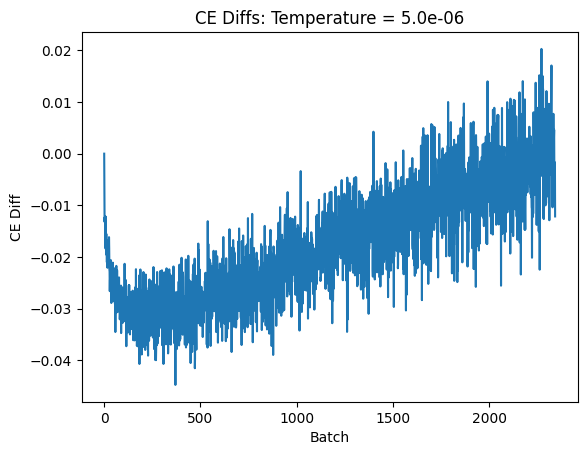

Correlation: -0.264


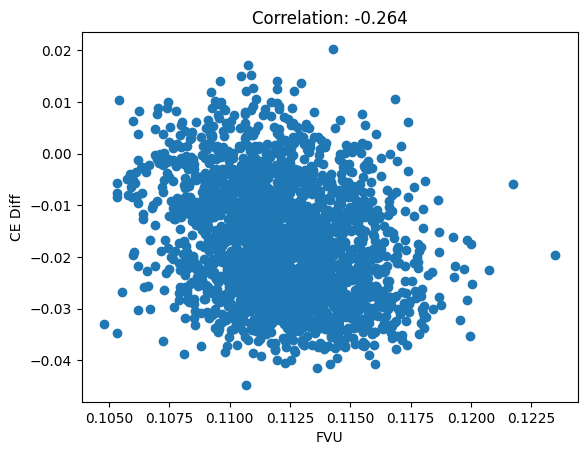

In [4]:
# We basically want to plot the CE-diff over the batches
import matplotlib.pyplot as plt
plot_dir = "plots"
os.makedirs(plot_dir, exist_ok=True)
# fvus, all_ce_diffs, ce_loss
plt.plot(all_ce_diffs)
plt.ylabel("CE Diff")
plt.xlabel("Batch")
plt.title(f"CE Diffs: Temperature = {temperature:.1e}")
# save the plot
plt.savefig(f"{plot_dir}/CE_diffs_temp={temperature:.1e}.png")
plt.show()
# Expicitely calculate correlation 
correlation = np.corrcoef(fvus, all_ce_diffs)[0, 1]
print(f"Correlation: {correlation:.3f}")
plt.scatter(fvus, all_ce_diffs)
plt.ylabel("CE Diff")
plt.xlabel("FVU")
plt.title(f"Correlation: {correlation:.3f}")
# save the plot
plt.savefig(f"{plot_dir}/FVU_CE_diffs_temp={temperature:.1e}.png")
plt.show()